# Analysis and Visualisation 

## Load preprocessed data

In [1]:
#!pip install datasets
#!pip install gensim

In [1]:
import datasets
from datasets import load_dataset, load_from_disk

tldr_cleaned_sample = load_from_disk('tldr_cleaned_sample')


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math

import numpy as np
from wordcloud import WordCloud
from matplotlib import cm
from matplotlib.colors import Normalize
import torch

## First overview

In [3]:
tldr_cleaned_sample

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short'],
    num_rows: 615392
})

### Predefine colors <3

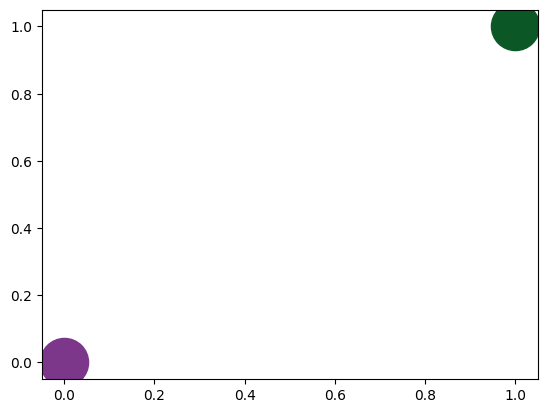

In [4]:
colormap = plt.get_cmap('PRGn')  
plt.scatter(x = [0], y = [0], s =1200, color= colormap(30), label = 'intuition')
plt.scatter(x = [1], y = [1], s =1200, color= colormap(245), label = 'evidence')
intColor = colormap(30)
evColor = colormap(245)
baseColor = colormap(45)

## Start with comparison of EMI scores of subreddits

### Show subreddits EMI score

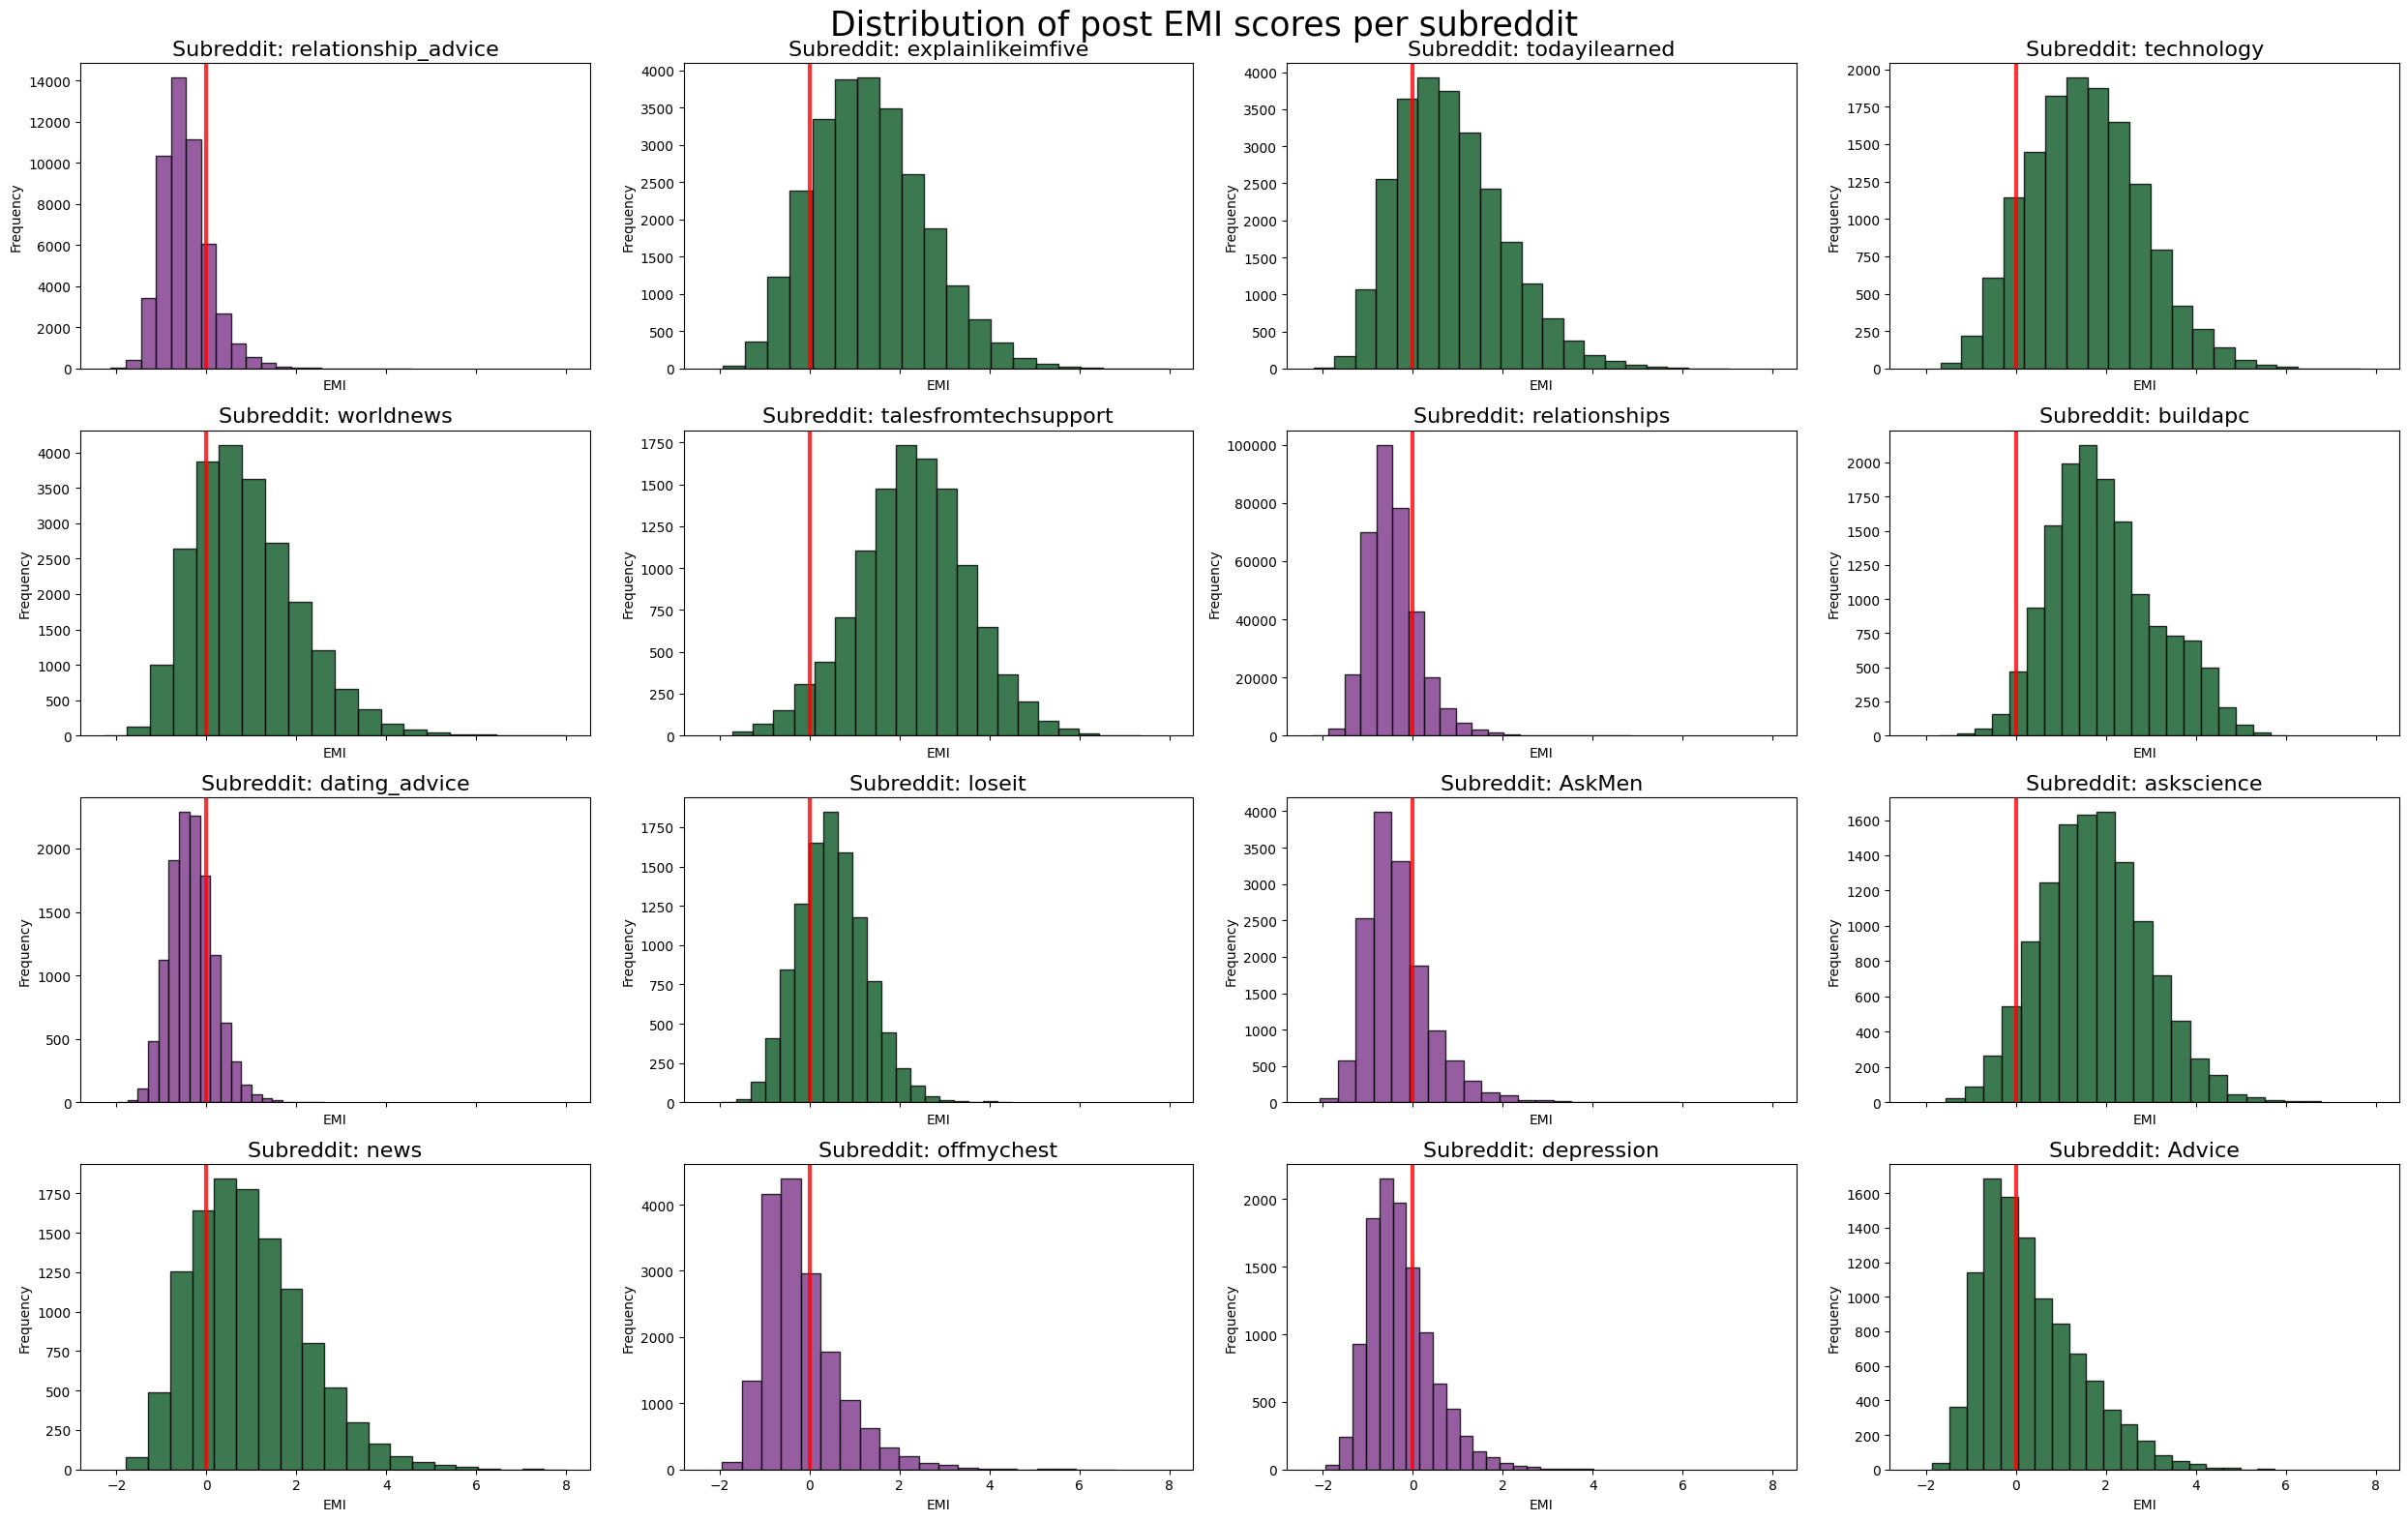

In [6]:
# to pandas for easier visualisation 
tldr_df = tldr_cleaned_sample.to_pandas()
# histograms 
subreddits = tldr_df['subreddit'].unique()
num_subreddits = len(subreddits)

#plt.figure(figsize=(5 * num_subreddits, 15))
fig, axs = plt.subplots(math.ceil(num_subreddits/4),4, figsize=(25, num_subreddits), sharex = True)
axs = axs.flatten()
for i, subreddit in enumerate(subreddits):
    #plt.subplot(2, round(num_subreddits/2), i + 1)
    subset = tldr_df[tldr_df['subreddit'] == subreddit]
    mean_emi = subset['emi'].mean()
    color = evColor if mean_emi > 0 else intColor
    axs[i].hist(subset['emi'], bins=20, color= color, edgecolor='black', alpha = 0.8)
    axs[i].set_title(f"Subreddit: {subreddit}", size = 16)
    axs[i].set_xlabel('EMI')
    axs[i].set_ylabel('Frequency')
    axs[i].axvline(0, color = 'red', linewidth = 3, alpha = 0.8 )
fig.suptitle('Distribution of post EMI scores per subreddit', fontsize = 25)
fig.subplots_adjust(top=0.9)
fig.tight_layout()
plt.show()

2.771295071584624e-19
1.0962529435173076


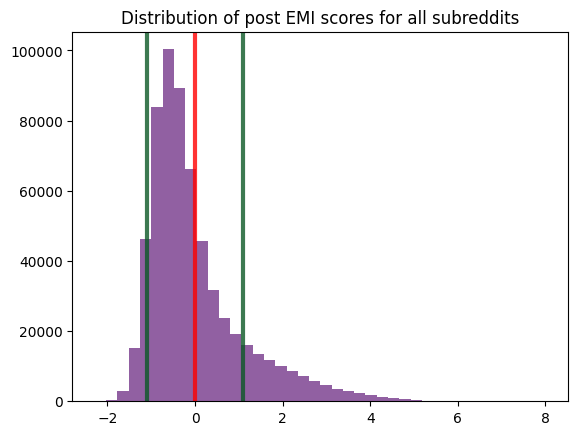

In [7]:
print(tldr_df['emi'].mean())
print(tldr_df['emi'].std())
plt.title('Distribution of post EMI scores for all subreddits')
plt.hist(tldr_df['emi'], bins=40, color=baseColor)
plt.axvline(tldr_df['emi'].mean(), color = 'red', linewidth = 3, alpha = 0.8)
plt.axvline(tldr_df['emi'].mean()+tldr_df['emi'].std(), color = evColor, linewidth = 3, alpha = 0.8)
plt.axvline(tldr_df['emi'].mean()-tldr_df['emi'].std(), color = evColor, linewidth = 3, alpha = 0.8)
plt.show()

# The BERT Part

## Test procedure on a sample

In [4]:
from transformers import BertTokenizer, BertModel
import torch

In [5]:
# create sample
sample = tldr_cleaned_sample.select(np.arange(500000,615392))

# run over the whole sample
#sample = tldr_cleaned_sample

sample


Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short'],
    num_rows: 115392
})

In [6]:
# Load tokenizer and model — set output_hidden_states=True
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Get the post embeddings

In [7]:
# split posts into sentences
import nltk
from nltk.tokenize import sent_tokenize

def split_into_sentences(post):
    return sent_tokenize(post)


In [8]:
# calc the cls embedding for each sentence
# mean all the cls embeddings of a post to get the post embedding

def get_post_embedding_from_sentences(sentences, tokenizer, model):
    cls_embeddings = []

    for sent in sentences:
        inputs = tokenizer(sent, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        cls_tokens = [layer[0, 0, :] for layer in hidden_states[-4:]]
        cls_mean = torch.mean(torch.stack(cls_tokens), dim=0)
        cls_embeddings.append(cls_mean)

    # Aggregate across all sentence embeddings (mean pooling)
    post_embedding = torch.mean(torch.stack(cls_embeddings), dim=0)
    return post_embedding.numpy()


In [10]:
# apply both functions to the dataset
"""
def process_post(example):
    sentences = split_into_sentences(example["content"])
    embedding = get_post_embedding_from_sentences(sentences, tokenizer, model)
    example["cls_embedding"] = embedding
    return example

embeddings = sample.map(process_post)
"""



#### batched Version

In [9]:
def process_post_batch(batch):
    # batch["content"] is a list of strings
    all_embeddings = []
    for content in batch["content"]:
        sentences = split_into_sentences(content)
        embedding = get_post_embedding_from_sentences(sentences, tokenizer, model)
        all_embeddings.append(embedding)
    
    # You return a dictionary of lists
    return {"cls_embedding": all_embeddings}

"""
embeddings = sample.map(
    process_post_batch,
    batched=True,
    batch_size=16  # You can adjust this for your system's memory capacity
)
"""



"\nembeddings = sample.map(\n    process_post_batch,\n    batched=True,\n    batch_size=16  # You can adjust this for your system's memory capacity\n)\n"

#### batched Version with intermediate storage of the result


In [ ]:
# This chunk runs (if applied to the full dataset ~615000) for around 100h
import os
import pickle
from tqdm import tqdm

# File path where embeddings are saved
SAVE_PATH = "cls_embeddings.pkl"

# Try to load existing embeddings
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "rb") as f:
        saved_embeddings = pickle.load(f)
else:
    saved_embeddings = {}  # dict: {post_id: embedding}

# Create a list of posts that need to be processed
posts_to_process = [ex for ex in sample if ex["id"] not in saved_embeddings]

print(f"Total posts to process: {len(posts_to_process)}")

# Batch processing
BATCH_SIZE = 16
SAVE_EVERY = 100
processed_count = 0

for i in tqdm(range(0, len(posts_to_process), BATCH_SIZE)):
    batch = posts_to_process[i:i+BATCH_SIZE]
    
    # Extract content and ids
    contents = [ex["content"] for ex in batch]
    ids = [ex["id"] for ex in batch]

    # Use your batched function directly
    batch_dict = {"content": contents}
    result = process_post_batch(batch_dict)
    batch_embeddings = result["cls_embedding"]

    # Update saved_embeddings
    for pid, emb in zip(ids, batch_embeddings):
        saved_embeddings[pid] = emb

    processed_count += len(batch)

    # Save intermediate result every SAVE_EVERY examples
    if processed_count % SAVE_EVERY == 0 or i + BATCH_SIZE >= len(posts_to_process):
        with open(SAVE_PATH, "wb") as f:
            pickle.dump(saved_embeddings, f)
        print(f"✅ Saved {processed_count} embeddings so far.")

print("🎉 Done!")


### Get the embeddings from the pickle
RUn if your curious about the distribution of the subreddits in the bert sample

Filter:   0%|          | 0/615392 [00:00<?, ? examples/s]

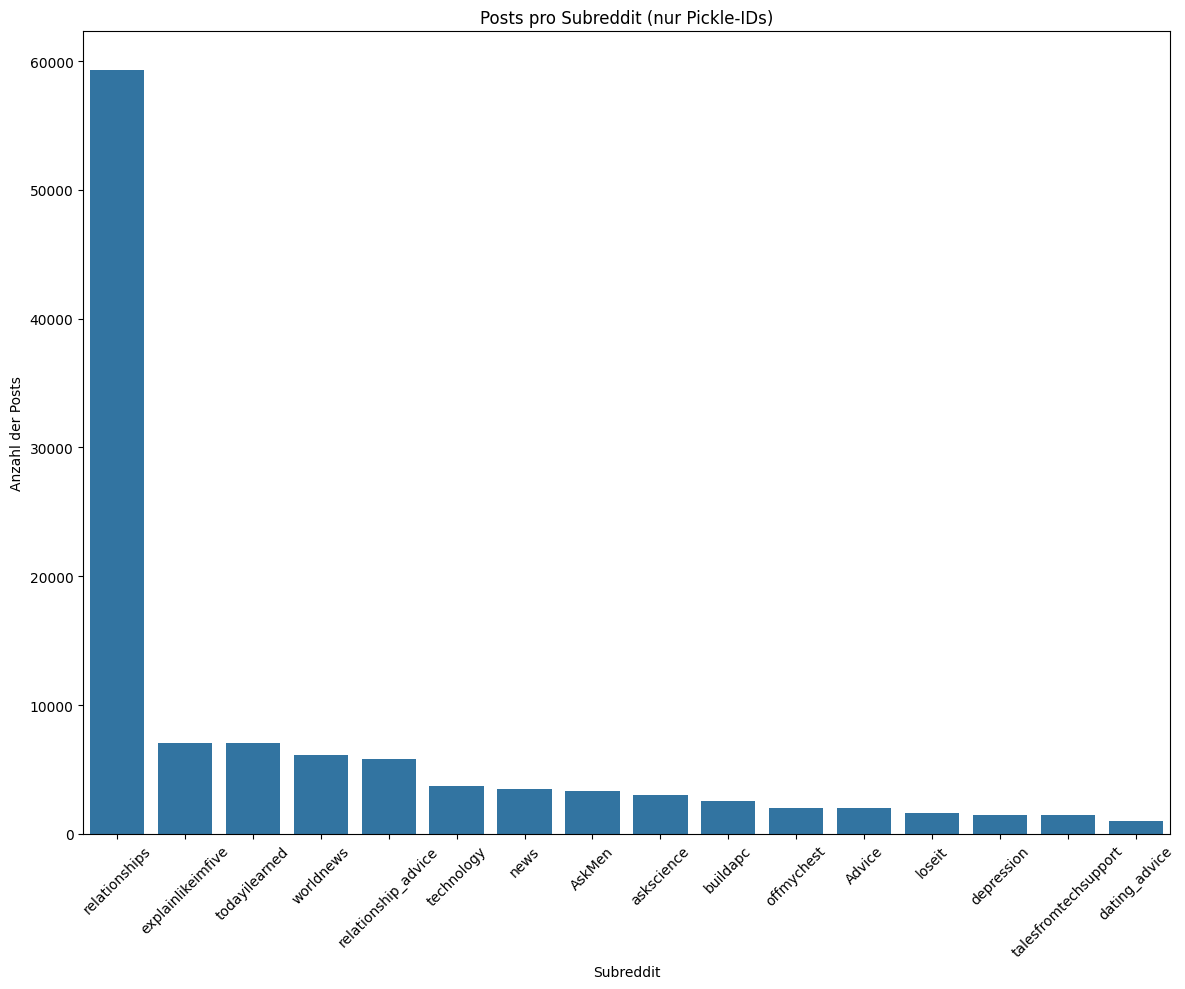

In [11]:
import pickle
import seaborn as sns


with open("cls_embeddings.pkl", "rb") as f:
    embedding_dict = pickle.load(f)

post_ids_in_pickle = set(embedding_dict.keys())

# only keep col of interest
dataset = tldr_cleaned_sample.remove_columns([col for col in tldr_cleaned_sample.column_names if col not in ['id', 'subreddit']])

# only keep rows of interest
filtered_dataset = dataset.filter(lambda example: example['id'] in post_ids_in_pickle)

df = filtered_dataset.to_pandas()

# Subreddit zählen
subreddit_counts = df['subreddit'].value_counts()

# Barplot
plt.figure(figsize=(12, 10))
sns.barplot(x=subreddit_counts.index, y=subreddit_counts.values)
plt.title("Posts pro Subreddit (nur Pickle-IDs)")
plt.xlabel("Subreddit")
plt.ylabel("Anzahl der Posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [46]:
"""
embedding_dict_share = {k: "known" for k in embedding_dict}
embedding_dict_share
"""


{'c6da92z': 'known',
 'c6dj2mm': 'known',
 'c6dydfx': 'known',
 'c6fyyak': 'known',
 'c6hlkqq': 'known',
 'c6honxu': 'known',
 'c6hrm48': 'known',
 'c6hy9sx': 'known',
 'c6log5w': 'known',
 'c6k1haj': 'known',
 'c6nhacv': 'known',
 'c6nhaif': 'known',
 'c6pgd46': 'known',
 'c6shtnp': 'known',
 'c6uuk2y': 'known',
 'c6whsmv': 'known',
 'c6x66u9': 'known',
 'c6x6cdp': 'known',
 'c6xwvfl': 'known',
 'c6y0tmg': 'known',
 'c6y0u99': 'known',
 'c6xyxbk': 'known',
 'c6y9grw': 'known',
 'c6yj68l': 'known',
 'c72vra3': 'known',
 'c72un60': 'known',
 'c776ef3': 'known',
 'c78y7uw': 'known',
 'c793s0m': 'known',
 'c7977jz': 'known',
 'c79f0xb': 'known',
 'c7aj68b': 'known',
 'c7czlbm': 'known',
 'c7fuozw': 'known',
 'c7gp9j6': 'known',
 'c7gz41h': 'known',
 'c7h45me': 'known',
 'c7iqjy3': 'known',
 'c7k5b4p': 'known',
 'c7kdkin': 'known',
 'c7kjdv2': 'known',
 'c7kkhii': 'known',
 'c7knaw2': 'known',
 'c7khbr2': 'known',
 'c7lrhqj': 'known',
 'c7lvrze': 'known',
 'c7lvxt7': 'known',
 'c7mp0p1': '

In [20]:
#len(embedding_dict_share)

111000

In [48]:
# store the ids of all known embeddigns:
"""
with open(SAVE_PATH, "wb") as f:
    pickle.dump(embedding_dict_share, f)
"""


### Get the dictionary embeddings

Used ChatGPT to generate sentences for each word in the dictionary  
For the intuition dictionary the LLM was additionally prompted to check the list and offer alternatives for unsure cases.
Some manual editing

In [12]:
evidence_sentences = {
    "accurate": "The report was highly accurate in its details.",
    "exact": "She needed the exact measurements for the experiment.",
    "intelligence": "The agency gathered intelligence about the situation.",
    "precise": "His explanation was precise.",
    "search": "They began a thorough search for the missing data.",
    "analyse": "We need to analyse the results before making a decision.",
    "examination": "The doctor conducted a full examination.",
    "investigate": "Scientists plan to investigate the root cause.",
    "procedure": "Follow the procedure step by step.",
    "show": "The results show a pattern.",
    "analysis": "The data analysis revealed trends.",
    "examine": "She will examine the samples tomorrow.",
    "investigation": "An investigation was launched into the findings.",
    "process": "The process took several hours to complete.",
    "statistics": "The statistics support the initial hypothesis.",
    "correct": "He gave the correct answer after reviewing the facts.",
    "expert": "An expert was consulted to verify the claim.",
    "knowledge": "Her knowledge in biology helped interpret the results.",
    "proof": "We still need proof before drawing conclusions.",
    "study": "They published a study in a peer-reviewed journal.",
    "correction": "A correction was issued after the mistake was found.",
    "explore": "We aim to explore this phenomenon in more detail.",
    "lab": "She spent hours working in the lab.",
    "question": "That question requires careful analysis.",
    "trial": "The trial was conducted over several months.",
    "data": "The data was collected from various sources.",
    "fact": "It is a fact supported by multiple studies.",
    "learn": "We hope to learn more from this research.",
    "read": "He decided to read the full report.",
    "real": "The effects were real and measurable.",
    "dossier": "The agent compiled a dossier on the subject.",
    "find": "They were able to find a correlation.",
    "logic": "Her argument was based on clear logic.",
    "reason": "There is a scientific reason for this outcome.",
    "true": "It turned out to be true after verification.",
    "education": "Education is crucial for scientific literacy.",
    "findings": "The findings were published last week.",
    "logical": "It is a logical conclusion based on the facts.",
    "research": "Ongoing research supports the hypothesis.",
    "truth": "We must seek the truth through evidence.",
    "evidence": "There is strong evidence to support the theory.",
    "information": "The report contains useful information.",
    "method": "The method was tested and peer-reviewed.",
    "science": "Science plays a key role in understanding reality.",
    "truthful": "She gave a truthful account of the experiment.",
    "evident": "It was evident that more testing was needed.",
    "inquiry": "An official inquiry was launched into the issue.",
    "pinpoint": "They tried to pinpoint the source of the error.",
    "scientific": "We need a scientific explanation for this."
}


In [13]:
intuition_sentences = {
    "advice": "She gave me advice based on her experience.",
    "doubt": "There was doubt about the accuracy of the statement.",
    "mislead": "Some people felt misled.",
    "suggestion": "He offered a helpful suggestion during the meeting.",
    "belief": "Her belief influenced how she interpreted the facts.",
    "fake": "She had a gut feeling the story might be fake, despite no clear proof.",
    "mistaken": "I might be mistaken, but it just does not feel right.",
    "suspicion": "The scientist raised a suspicion about the data.",
    "believe": "Many people believe the story without evidence.",
    "fake news": "To her, it just seemed like fake news, though she couldn't explain why.",
    "mistrust": "There is growing mistrust toward the source.",
    "view": "His view on the topic differed from the consensus.",
    "bogus": "It sounded bogus to him.",
    "feeling": "She had a feeling something was not right.",
    "opinion": "The editorial reflects the writer’s opinion.",
    "viewpoint": "From her viewpoint, the results were inconclusive.",
    "common sense": "Common sense suggests a different conclusion.",
    "genuine": "It felt genuine, even if others weren't convinced.",
    "perspective": "That perspective adds a new angle to the issue.",
    "wrong": "Something felt wrong, though I could not point to any facts.",
    "deceive": "He worried they might be trying to deceive people, but it was just a feeling.",
    "guess": "My guess is that the numbers are off.",
    "phony": "It came across as phony.",
    "deception": "She sensed some deception, though she couldn't articulate the reason.",
    "gut": "I went with my gut on this one.",
    "point of view": "Her point of view shaped her interpretation.",
    "dishonest": "It struck him as dishonest",
    "instinct": "He trusted his instinct in making the call.",
    "propaganda": "It felt like propaganda.",
    "dishonesty": "Her intuition told her there was some dishonesty involved.",
    "intuition": "She relied on intuition to guide her choice.",
    "sense": "There was a sense that something was off.",
    "distrust": "Distrust in the media has increased recently.",
    "lie": "It seems to be a lie.",
    "suggest": "Some suggest this is the right path."
}


In [14]:
def get_contextual_embedding(dictionary, tokenizer, model):
    embeddings = []
    for key in dictionary:
        sentence = dictionary[key]
        inputs = tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states
        cls_emb = torch.stack([hidden_states[-i][0, 0] for i in range(1, 5)]).mean(0)
        embeddings.append(cls_emb)
    return torch.stack(embeddings).mean(0)  # Average over templates

# Example
evidence_vector = get_contextual_embedding(evidence_sentences, tokenizer, model)
intuition_vector = get_contextual_embedding(intuition_sentences, tokenizer, model)

### Visualize the positioning of the posts and the dictionary vectors
Run only if you are interested in the visualisation

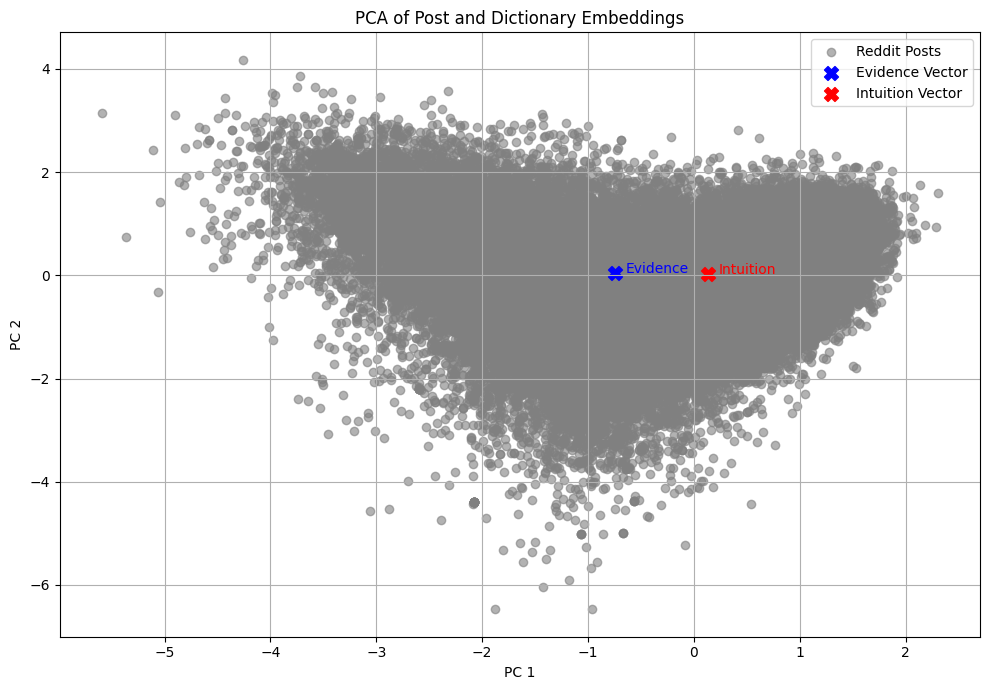

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the post embeddings
post_embeddings = list(embedding_dict.values()) #embeddings["cls_embedding"]

# Stack vectors: post_embeddings should be a list or array of shape (n_posts, 768)
all_vectors = np.vstack([post_embeddings, evidence_vector, intuition_vector])

# Apply PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_vectors)

# Separate components
post_reduced = reduced[:-2]
evidence_reduced = reduced[-2]
intuition_reduced = reduced[-1]

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(post_reduced[:, 0], post_reduced[:, 1], color='gray', alpha=0.6, label='Reddit Posts')
plt.scatter(*evidence_reduced, color='blue', marker='X', s=100, label='Evidence Vector')
plt.scatter(*intuition_reduced, color='red', marker='X', s=100, label='Intuition Vector')
plt.text(evidence_reduced[0]+0.1, evidence_reduced[1], 'Evidence', color='blue')
plt.text(intuition_reduced[0]+0.1, intuition_reduced[1], 'Intuition', color='red')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA of Post and Dictionary Embeddings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
# filter out all rows that we have no embeddings of
tldr_cleaned_sample

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short'],
    num_rows: 615392
})

### Merge with Embeddings (in a dict) to the huggingface dataset

In [49]:
# double check the types
print(type(sample[0]["id"]))
key_types = set(type(k) for k in embedding_dict.keys())
print(key_types)


<class 'str'>
{<class 'str'>}


In [27]:

# Step 1: Define a function to add cls_embedding (or return None if no match)
def add_cls_embedding(example):
    post_id = example["id"]
    if post_id in embedding_dict:
        example["cls_embedding"] = embedding_dict[post_id]
    else:
        example["cls_embedding"] = None
    return example

# Step 2: Apply the function
embeddings = tldr_cleaned_sample.map(add_cls_embedding)

# Step 3: Filter out entries where cls_embedding is None (i.e., no match)
embeddings = embeddings.filter(lambda x: x["cls_embedding"] is not None)

# Now 'sample' contains only rows where 'id' matched and 'cls_embedding' was added
embeddings

Map:   0%|          | 0/615392 [00:00<?, ? examples/s]

Filter:   0%|          | 0/615392 [00:00<?, ? examples/s]

Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short', 'cls_embedding'],
    num_rows: 111000
})

### Calculate the EMI Score

In [28]:
# cosine similarity for map
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_a = np.linalg.norm(vec1)
    norm_b = np.linalg.norm(vec2)
    
    if norm_a == 0 or norm_b == 0:
        return 0.0  # Avoid division by zero
    
    return dot_product / (norm_a * norm_b)

In [29]:
def get_emi_token(example, col = 'cls_embedding'):
    
    # Get the word vectors for the valid tokens
    evidence_sim = np.float32(cosine_similarity(example[col], evidence_vector)) # removed from args
    intuition_sim = np.float32(cosine_similarity(example[col], intuition_vector))

    example["evidence_sim_b"] = evidence_sim
    example["intuition_sim_b"] = intuition_sim
    
    return example

sample = embeddings.map(get_emi_token)
sample

Map:   0%|          | 0/111000 [00:00<?, ? examples/s]

/tmp/ipykernel_4796/471402982.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dot_product = np.dot(vec1, vec2)


Dataset({
    features: ['author', 'body', 'normalizedBody', 'subreddit', 'subreddit_id', 'id', 'content', 'summary', 'clean', 'avg_vec', 'evidence_sim', 'intuition_sim', 'length_bin', 'z_evidence', 'z_intuition', 'emi', 'clean_short', 'avg_vec_short', 'evidence_sim_short', 'intuition_sim_short', 'length_bin_short', 'z_evidence_short', 'z_intuition_short', 'emi_short', 'cls_embedding', 'evidence_sim_b', 'intuition_sim_b'],
    num_rows: 111000
})

### Binning by post length

additional optimization by the original paper  
take from Nina

In [30]:
bin_stats = {}

for bin_id in sorted(set(sample["length_bin"])):
    bin_data = sample.filter(lambda x: x["length_bin"] == bin_id)
    
    evidence_values = bin_data["evidence_sim_b"]
    intuition_values = bin_data["intuition_sim_b"]
    
    stats = {
        "evidence_sim_mean": np.mean(evidence_values),
        "evidence_sim_std": np.std(evidence_values, ddof=1),  
        "intuition_sim_mean": np.mean(intuition_values),
        "intuition_sim_std": np.std(intuition_values, ddof=1),  
    }
    
    bin_stats[bin_id] = stats

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/111000 [00:00<?, ? examples/s]

### Z-Standardization per bin

In [31]:
# z by bin 
def center_by_bin(example):
    bin_id = example['length_bin']
    stats = bin_stats[bin_id]

    # Compute z-scores
    z_evidence = (example['evidence_sim_b'] - stats['evidence_sim_mean']) / stats['evidence_sim_std'] + 1e-20
    z_intuition = (example['intuition_sim_b'] - stats['intuition_sim_mean']) / stats['intuition_sim_std'] + 1e-20
    
    emi = z_evidence - z_intuition
    
    return {
        'z_evidence_b': z_evidence,
        'z_intuition_b': z_intuition,
        'emi_bert': emi
    }
sample = sample.map(center_by_bin)

Map:   0%|          | 0/111000 [00:00<?, ? examples/s]

In [39]:
# 1. Select only the columns you want
subset = sample.select_columns(["id", "emi_bert"])

# 2. Convert to pandas DataFrame
df = subset.to_pandas()

# 3. Export to CSV 
# TODO: change the output_name to avoid overwriting
df.to_csv("emi_bert.csv", index=False)

# Run till here (the next few chunks are some analytics if your interested)

### Correlation emi_bert and emi_w2v

In [41]:
emi_bert = sample["emi_bert"]

In [40]:
emi_w2v = sample["emi"] 

(array([7.0000e+00, 4.5000e+01, 2.3500e+02, 9.7300e+02, 3.0360e+03,
        6.5710e+03, 1.0391e+04, 1.2453e+04, 1.2548e+04, 1.0846e+04,
        8.8600e+03, 6.9770e+03, 5.5040e+03, 4.4060e+03, 3.8680e+03,
        3.3430e+03, 2.9660e+03, 2.6880e+03, 2.3030e+03, 2.1000e+03,
        1.8270e+03, 1.5760e+03, 1.4360e+03, 1.2060e+03, 1.0100e+03,
        8.5700e+02, 6.8100e+02, 5.2700e+02, 4.2200e+02, 3.2900e+02,
        2.6400e+02, 2.2000e+02, 1.5200e+02, 9.9000e+01, 8.4000e+01,
        5.8000e+01, 3.2000e+01, 2.7000e+01, 2.1000e+01, 1.8000e+01,
        6.0000e+00, 6.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([-2.21402627, -2.0096005 , -1.80517473, -1.60074895, -1.39632318,
        -1.1918974 , -0.98747163, -0.78304586, -0.57862008, -0.37419431,
        -0.16976854,  0.03465724,  0.23908301,  0.44350879,  0.64793456,
         0.85236033,  1.05678611,  1.26121188,  1.46563765,  1.67006343,
         1.8744892 ,  2.07

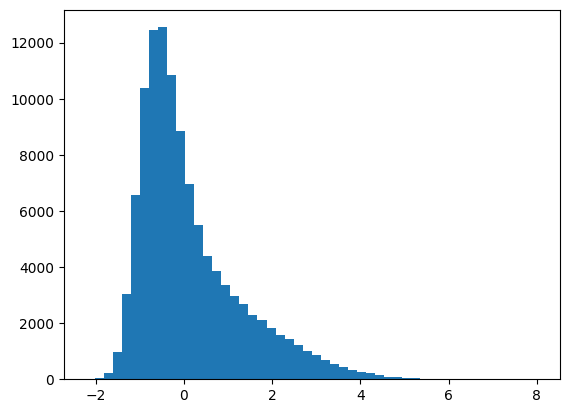

In [34]:
plt.hist(emi_w2v, bins = 50)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 2.0000e+00, 1.8000e+01, 4.2000e+01, 8.2000e+01,
        2.3100e+02, 6.2400e+02, 1.2750e+03, 2.4790e+03, 4.5370e+03,
        7.2200e+03, 1.0688e+04, 1.4113e+04, 1.6386e+04, 1.5890e+04,
        1.2472e+04, 8.8240e+03, 5.6810e+03, 3.7840e+03, 2.5110e+03,
        1.6450e+03, 1.0140e+03, 6.6600e+02, 3.6100e+02, 2.5800e+02,
        1.2300e+02, 3.8000e+01, 1.7000e+01, 6.0000e+00, 8.0000e+00]),
 array([-5.59110139e+00, -5.42665396e+00, -5.26220654e+00, -5.09775912e+00,
        -4.93331169e+00, -4.76886427e+00, -4.60441684e+00, -4.43996942e+00,
        -4.27552200e+00, -4.11107457e+00, -3.94662715e+00, -3.78217973e+00,
        -3.61773230e+00, -3.45328488e+00, -3.28883746e+00, -3.12439003e+00,
        -2.959

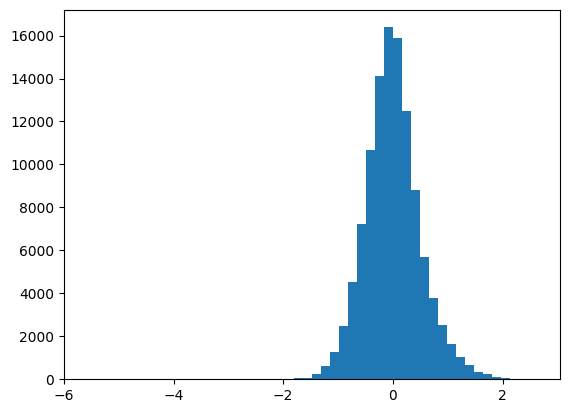

In [42]:
plt.hist(emi_bert, bins = 50)

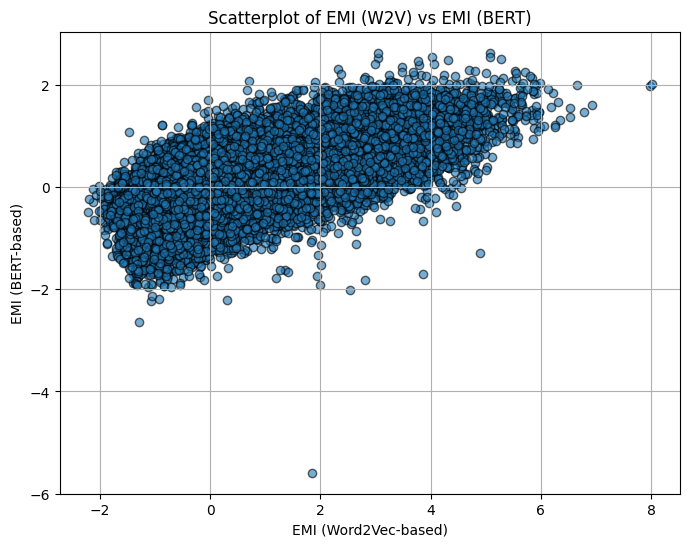

In [43]:
# Scatterplot

plt.figure(figsize=(8, 6))
plt.scatter(emi_w2v, emi_bert, alpha=0.6, edgecolors='k')
plt.xlabel("EMI (Word2Vec-based)")
plt.ylabel("EMI (BERT-based)")
plt.title("Scatterplot of EMI (W2V) vs EMI (BERT)")
plt.grid(True)
plt.show()


In [45]:
from scipy import stats

# remove nas

# Convert to numpy arrays
emi_w2v = np.array(emi_w2v)
emi_bert = np.array(emi_bert)

# Filter out NaNs
mask = ~np.isnan(emi_w2v) & ~np.isnan(emi_bert)
emi_w2v_clean = emi_w2v[mask]
emi_bert_clean = emi_bert[mask]

print("Std EMI (w2v):", np.std(emi_w2v_clean))
print("Std EMI (bert):", np.std(emi_bert_clean))

pearson_corr, _ = stats.pearsonr(emi_w2v_clean, emi_bert_clean)
spearman_corr, _ = stats.spearmanr(emi_w2v_clean, emi_bert_clean)

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")


Std EMI (w2v): 1.1624758533615567
Std EMI (bert): 0.504683241759473
Pearson correlation: 0.666
Spearman correlation: 0.631
